In [ ]:
!pip install gplearn

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

from gplearn.genetic import SymbolicRegressor

import time
plt.rcParams["figure.dpi"] = 120

In [ ]:
# Scenario A data (x column)
scenario_a_train = pd.read_csv("scenario_a_train.csv")
scenario_a_test  = pd.read_csv("scenario_a_test.csv")

# Scenario B data (t column)
scenario_b_train = pd.read_csv("scenario_b_train.csv")
scenario_b_test  = pd.read_csv("scenario_b_test.csv")

# Scenario C data (t column)
scenario_c_train = pd.read_csv("scenario_c_train.csv")
scenario_c_test  = pd.read_csv("scenario_c_test.csv")

scenario_a_train.head(), scenario_b_train.head(), scenario_c_train.head()

(          x         y    y_true
 0 -2.369369 -0.039157 -0.136339
 1 -2.591592  0.103582  0.148947
 2 -0.123123 -0.096496 -0.121296
 3 -0.603604 -0.488552 -0.531179
 4 -0.393393 -0.416404 -0.367849,
           t         y    y_true
 0  0.157658  1.463206  1.454737
 1  0.102102  1.079187  0.969908
 2  0.719219  4.627647  4.662393
 3  0.599099  4.340321  4.234790
 4  0.651652  4.496488  4.439143,
           t         y    y_true
 0  2.102102 -0.376110 -0.427816
 1  1.361361  0.220144  0.209658
 2  9.589590 -0.478402 -0.476985
 3  7.987988 -0.103209 -0.120176
 4  8.688689 -0.422326 -0.421094)

In [27]:
# ---- Physics priors for Hybrid ----

def phys_prior_scenario_a(X):
    x = X[:, 0]
    return np.sin(x)

def phys_prior_scenario_b(X):
    g = 9.81
    v0 = 10.0
    t = X[:, 0]
    return v0 * t - 0.5 * g * t**2

def phys_prior_scenario_c(X):
    t = X[:, 0]
    return np.cos(t)   # deliberately crude prior

In [28]:
# ---- True laws (for plotting only) ----

def true_law_a(x):
    return np.sin(x) + 0.1 * x**2

def true_law_b(t):
    g = 9.81
    v0 = 10.0
    return v0 * t - 0.5 * g * t**2 + 0.02 * t**3

def true_law_c(t_array):
    """
    Nonlinear oscillator:
        y'' + 0.15 y' + y + 0.1 y^3 = 0,  y(0)=1, y'(0)=0
    """
    def ode(t, z):
        y, v = z
        dydt = v
        dvdt = -0.15 * v - y - 0.1 * y**3
        return [dydt, dvdt]

    t_array = np.asarray(t_array)
    t_span = (float(t_array.min()), float(t_array.max()))
    sol = solve_ivp(ode, t_span, [1.0, 0.0], t_eval=t_array)
    return sol.y[0]

In [31]:
def run_scenario(
    name,
    train_df,
    test_df,
    input_col,
    phys_prior_fn,
    fig_name,
    true_law_fn=None,
):
    """
    Run Neural Network (ReLU), Symbolic Regression, and Hybrid (physics + symbolic residual)
    on one scenario, with training times.

    Hybrid model:
        y(x) = y_phys(x) + r_sr(x)
    where y_phys is the analytic prior and r_sr is a symbolic regressor fit to the residual.
    """

    print(f"\n=== Scenario: {name} ===")

    # ---------- Data ----------
    X_train_raw = train_df[[input_col]].values
    y_train = train_df["y"].values

    X_test_raw = test_df[[input_col]].values
    y_test = test_df["y"].values
    y_true_test = test_df["y_true"].values  # for reference only

    # ---------- Scale input (for NN only) ----------
    x_mean = X_train_raw.mean()
    x_std = X_train_raw.std()
    X_train = (X_train_raw - x_mean) / x_std
    X_test = (X_test_raw - x_mean) / x_std

    # =====================================================
    # 1. Neural Network (ReLU) baseline
    # =====================================================
    start_nn = time.perf_counter()
    nn = MLPRegressor(
        hidden_layer_sizes=(64, 64),
        activation="relu",
        max_iter=10000,
        random_state=0,
    )
    nn.fit(X_train, y_train)
    end_nn = time.perf_counter()
    time_nn = end_nn - start_nn

    y_pred_nn = nn.predict(X_test)
    mse_nn = mean_squared_error(y_test, y_pred_nn)

    # =====================================================
    # 2. Symbolic Regression (full mapping y = f(x))
    # =====================================================
    start_sr = time.perf_counter()
    sr_full = SymbolicRegressor(
        population_size=1000,
        generations=20,
        function_set=("add", "sub", "mul", "div", "sin", "cos"),
        metric="mse",
        parsimony_coefficient=0.001,
        verbose=0,
        random_state=0,
    )
    sr_full.fit(X_train_raw, y_train)
    end_sr = time.perf_counter()
    time_sr = end_sr - start_sr

    y_pred_sr = sr_full.predict(X_test_raw)
    mse_sr = mean_squared_error(y_test, y_pred_sr)

    print("Full SR expression:")
    print(sr_full._program)

    # =====================================================
    # 3. Hybrid = physics prior + symbolic residual
    # =====================================================
    # residual = y - y_phys
    y_phys_train = phys_prior_fn(X_train_raw)
    residual_train = y_train - y_phys_train

    start_hybrid = time.perf_counter()
    sr_resid = SymbolicRegressor(
        population_size=1000,
        generations=20,
        function_set=("add", "sub", "mul", "div", "sin", "cos"),
        metric="mse",
        parsimony_coefficient=0.001,
        verbose=0,
        random_state=1,
    )
    sr_resid.fit(X_train_raw, residual_train)
    end_hybrid = time.perf_counter()
    time_hybrid = end_hybrid - start_hybrid

    # Predictions
    y_phys_test = phys_prior_fn(X_test_raw)
    residual_pred_test = sr_resid.predict(X_test_raw)
    y_pred_hybrid = y_phys_test + residual_pred_test
    mse_hybrid = mean_squared_error(y_test, y_pred_hybrid)

    print("Hybrid residual SR expression (r(x)):")
    print(sr_resid._program)

    # Construct a readable hybrid equation string
    hybrid_equation_str = f"y(x) = [physics_prior({input_col})] + ({sr_resid._program})"

    # =====================================================
    # Plot for visualization
    # =====================================================
    x_min = min(train_df[input_col].min(), test_df[input_col].min())
    x_max = max(train_df[input_col].max(), test_df[input_col].max())
    X_plot_raw = np.linspace(x_min, x_max, 400).reshape(-1, 1)
    X_plot = (X_plot_raw - x_mean) / x_std

    if true_law_fn is not None:
        y_true_plot = true_law_fn(X_plot_raw[:, 0])
    else:
        y_true_plot = None

    y_nn_plot = nn.predict(X_plot)
    y_sr_plot = sr_full.predict(X_plot_raw)
    y_phys_plot = phys_prior_fn(X_plot_raw)
    y_hybrid_plot = y_phys_plot + sr_resid.predict(X_plot_raw)

    plt.figure(figsize=(7, 4))
    plt.scatter(X_train_raw[:, 0], y_train, s=10, alpha=0.3, label="Train data")

    if y_true_plot is not None:
        plt.plot(X_plot_raw[:, 0], y_true_plot, label="True law", linewidth=2)

    plt.plot(X_plot_raw[:, 0], y_nn_plot, "--", label="NN (ReLU)")
    plt.plot(X_plot_raw[:, 0], y_sr_plot, "--", label="Symbolic Regression")
    plt.plot(X_plot_raw[:, 0], y_hybrid_plot, "--", label="Hybrid (phys + SR residual)")

    plt.xlabel(input_col)
    plt.ylabel("y")
    plt.title(name)
    plt.legend()
    plt.tight_layout()
    plt.savefig(fig_name, dpi=200)
    plt.show()

    return {
        "name": name,
        "mse_nn": mse_nn,
        "mse_sr": mse_sr,
        "mse_hybrid": mse_hybrid,
        "time_nn": time_nn,
        "time_sr": time_sr,
        "time_hybrid": time_hybrid,
        "sr_full_expr": str(sr_full._program),
        "hybrid_residual_expr": str(sr_resid._program),
        "hybrid_equation": hybrid_equation_str,
    }


=== Scenario: Scenario A: y = sin(x) + 0.1 x^2 ===


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Full SR expression:
sub(sin(add(-0.337, X0)), -0.328)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Hybrid residual SR expression (r(x)):
sub(0.288, mul(mul(-0.866, -0.442), cos(X0)))


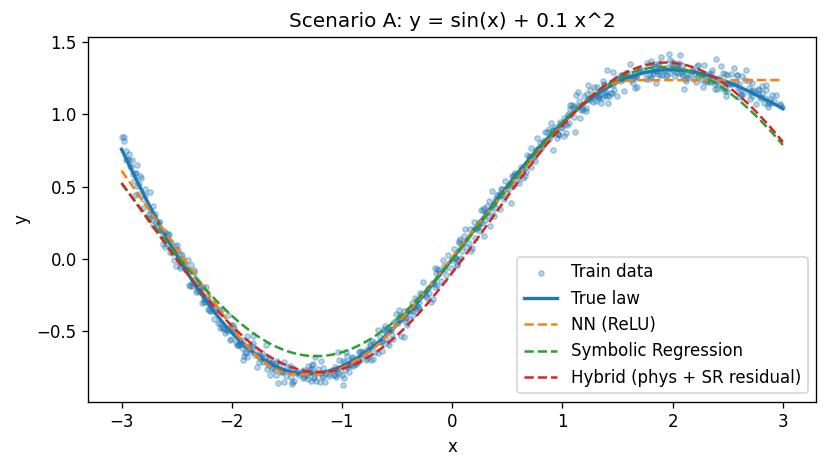


=== Scenario: Scenario B: projectile with cubic correction ===


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Full SR expression:
mul(add(mul(0.999, div(add(-0.009, X0), mul(0.362, X0))), sub(add(X0, 0.558), add(sin(mul(X0, 0.609)), div(sin(X0), mul(-0.492, 0.704))))), sin(cos(sub(sin(sub(div(sub(mul(X0, X0), mul(X0, X0)), 0.584), add(sin(mul(X0, 0.609)), div(sin(X0), mul(-0.492, 0.704))))), mul(cos(X0), sub(cos(X0), div(0.315, -0.597)))))))


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Hybrid residual SR expression (r(x)):
0.009


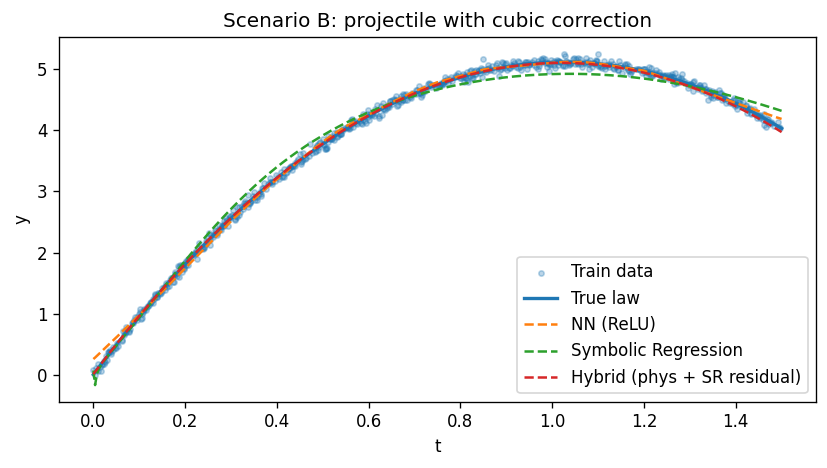


=== Scenario: Scenario C: nonlinear damped oscillator ===


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Full SR expression:
mul(0.495, cos(X0))


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Hybrid residual SR expression (r(x)):
mul(mul(cos(X0), mul(0.070, -0.661)), X0)


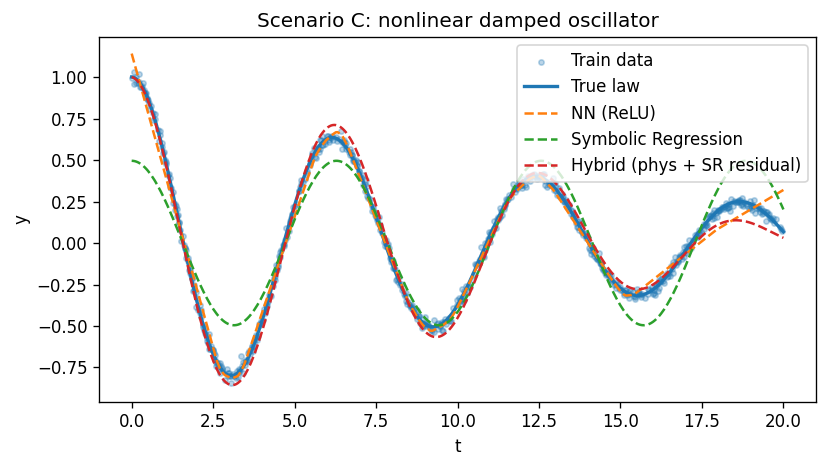


=== Summary (MSE on held-out test data) ===
Scenario A: y = sin(x) + 0.1 x^2
  NN (ReLU)      MSE: 4.924753e-03
  Symbolic Reg   MSE: 1.060228e-02
  Hybrid (phys+SR) MSE: 8.340099e-03

Scenario B: projectile with cubic correction
  NN (ReLU)      MSE: 5.812750e-03
  Symbolic Reg   MSE: 2.032719e-02
  Hybrid (phys+SR) MSE: 2.769623e-03

Scenario C: nonlinear damped oscillator
  NN (ReLU)      MSE: 4.257371e-03
  Symbolic Reg   MSE: 2.724807e-02
  Hybrid (phys+SR) MSE: 3.509965e-03


=== Training times (seconds) ===
Scenario A: y = sin(x) + 0.1 x^2
  NN (ReLU)      time: 0.3913
  Symbolic Reg   time: 16.0024
  Hybrid (phys+SR) time: 16.4874

Scenario B: projectile with cubic correction
  NN (ReLU)      time: 0.8447
  Symbolic Reg   time: 24.2308
  Hybrid (phys+SR) time: 16.2543

Scenario C: nonlinear damped oscillator
  NN (ReLU)      time: 0.6341
  Symbolic Reg   time: 17.7167
  Hybrid (phys+SR) time: 16.7053



In [32]:
results = []

results.append(
    run_scenario(
        name="Scenario A: y = sin(x) + 0.1 x^2",
        train_df=scenario_a_train,
        test_df=scenario_a_test,
        input_col="x",
        phys_prior_fn=phys_prior_scenario_a,
        fig_name="scenario_a_fit.png",
        true_law_fn=true_law_a,
    )
)

results.append(
    run_scenario(
        name="Scenario B: projectile with cubic correction",
        train_df=scenario_b_train,
        test_df=scenario_b_test,
        input_col="t",
        phys_prior_fn=phys_prior_scenario_b,
        fig_name="scenario_b_fit.png",
        true_law_fn=true_law_b,
    )
)

results.append(
    run_scenario(
        name="Scenario C: nonlinear damped oscillator",
        train_df=scenario_c_train,
        test_df=scenario_c_test,
        input_col="t",
        phys_prior_fn=phys_prior_scenario_c,
        fig_name="scenario_c_fit.png",
        true_law_fn=true_law_c,
    )
)

print("\n=== Summary (MSE on held-out test data) ===")
for r in results:
    print(
        f"{r['name']}\n"
        f"  NN (ReLU)      MSE: {r['mse_nn']:.6e}\n"
        f"  Symbolic Reg   MSE: {r['mse_sr']:.6e}\n"
        f"  Hybrid (phys+SR) MSE: {r['mse_hybrid']:.6e}\n"
    )

print("\n=== Training times (seconds) ===")
for r in results:
    print(
        f"{r['name']}\n"
        f"  NN (ReLU)      time: {r['time_nn']:.4f}\n"
        f"  Symbolic Reg   time: {r['time_sr']:.4f}\n"
        f"  Hybrid (phys+SR) time: {r['time_hybrid']:.4f}\n"
    )
